In [ ]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# AICellFate model with image data

In [1]:
# TODO: add the workflow from manuscript notebook that gives us the final confusion matrix values per random state per time point

In [ ]:
# load all confusion matrices

conf_matrix_cellfate_seed42 = np.sum((np.load('all_confusion_matrices_cellfate_6.npy'), np.load('all_confusion_matrices_cellfate_10.npy')), axis=0)
conf_matrix_cellfate_seed43 = np.sum((np.load('all_confusion_matrices_cellfate_seed43_3.npy'), np.load('all_confusion_matrices_cellfate_seed43_6.npy'), np.load('all_confusion_matrices_cellfate_seed43_10.npy')), axis=0)
conf_matrix_cellfate_seed44 = np.sum((np.load('all_confusion_matrices_cellfate_seed44_4.npy'), np.load('all_confusion_matrices_cellfate_seed44_10.npy')), axis=0)

conf_matrix_cellfate = np.stack((conf_matrix_cellfate_seed42, conf_matrix_cellfate_seed43, conf_matrix_cellfate_seed44), axis=0)

In [50]:
conf_matrix_cellfate[0,0][0,1]

0.34234234234234234

In [51]:
# calculate precisions

precision_cellfate = np.zeros((11, 3))
accuracy_cellfate = np.zeros((11, 3))
false_positives_cellfate = np.zeros((11, 3))
false_negatives_cellfate = np.zeros((11, 3))

for tp in range(conf_matrix_cellfate.shape[1]):
    for seed in range(conf_matrix_cellfate.shape[0]):
        conf_matrix = conf_matrix_cellfate[seed, tp]
        precision_cellfate[tp, seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
        accuracy_cellfate[tp, seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
        false_positives_cellfate[tp, seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
        false_negatives_cellfate[tp, seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [59]:
mean_precisions = np.mean(precision_cellfate, axis=1)
std_precisions = np.std(precision_cellfate, axis=1)

mean_accuracies = np.mean(accuracy_cellfate, axis=1)
std_accuracies = np.std(accuracy_cellfate, axis=1)

mean_false_positives = np.mean(false_positives_cellfate, axis=1)
std_false_positives = np.std(false_positives_cellfate, axis=1)

mean_false_negatives = np.mean(false_negatives_cellfate, axis=1)
std_false_negatives = np.std(false_negatives_cellfate, axis=1)

Plotting results of our model

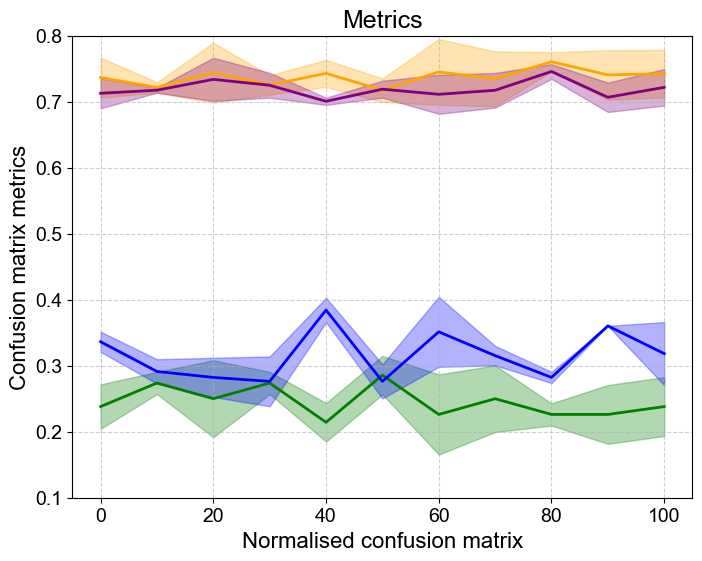

In [60]:
time_points = np.linspace(0, 100, len(mean_precisions))

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(time_points, mean_precisions, color='orange', linewidth=2)
plt.fill_between(time_points, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Accuracy (purple)
plt.plot(time_points, mean_accuracies, color='purple', linewidth=2)
plt.fill_between(time_points, mean_accuracies - std_accuracies, 
                 mean_accuracies + std_accuracies, color='purple', alpha=0.3)

# False Positives (green)
plt.plot(time_points, mean_false_positives, color='green', linewidth=2)
plt.fill_between(time_points, mean_false_positives - std_false_positives,
                 mean_false_positives + std_false_positives, color='green', alpha=0.3)

# False Negatives (blue)
plt.plot(time_points, mean_false_negatives, color='blue', linewidth=2)
plt.fill_between(time_points, mean_false_negatives - std_false_negatives,
                    mean_false_negatives + std_false_negatives, color='blue', alpha=0.3)

# Formatting
plt.xlabel("Normalised confusion matrix", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)

# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# MLP model with tabular data

In [ ]:
# TODO: add the workflow from manuscript notebook that gives us the final confusion matrix values per random state per time point

In [68]:
tabular_train = np.load('../data/tracks/time_norm_train_track.npy')
tabular_test = np.load('../data/tracks/time_norm_test_track.npy')
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")

In [81]:
test_labels = np.load('../data/labels/test_labels.npy')
train_tracks = np.load("../data/tracks/train_tracks.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

In [84]:
train_tracks_features = train_tracks[:, :, 4:17 ] 
test_tracks_features = test_tracks[:, :, 4:17]

In [88]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data

In [91]:
train_tracks_norm = normalize_cell_time(train_tracks_features)

In [96]:
np.nonzero(train_tracks_norm[:,0] == train_tracks_features[:,0])

(array([   0,    0,    0, ..., 1107, 1107, 1107]),
 array([ 0,  1,  2, ..., 10, 11, 12]))

In [ ]:
def complex_mlp_classifier(latent_dim): 
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

In [71]:
tabular_train.shape

(1108, 11, 13)

In [86]:
conf_matrix_tabular = np.zeros((3, 11, 2, 2)) # 3 random states, 11 time points, 2x2 confusion matrix

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

for seed in [42, 43, 44]:
    for i in range(2): #tabular_train.shape[1]
        frame = i
        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
        class_weights = dict(enumerate(class_weights))

        tf.keras.utils.set_random_seed(seed)

        classifier = complex_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 
        #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

        # Train the classifier
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
        classifier.summary()

        x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

        history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

        y_pred = classifier.predict(x_test_tracks)

        num_classes = len(np.unique(train_labels))
        threshold = 0.5
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_tracks, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        print(conf_matrix_normalized)

        conf_matrix_tabular[seed-42, i] = conf_matrix_normalized
        

        # all_confusion_matrices[i] = conf_matrix_normalized

        # precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
        # mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
        # print("frame", frame, "Precision: ", precision, "Mean diagonal: ", mean_diagonal)

        # precisions[i] = precision
        # mean_diagonals[i] = mean_diagonal


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_33          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6917 - loss: 0.7303 - val_accuracy: 0.8043 - val_loss: 0.5844
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6654 - loss: 0.6965 - val_accuracy: 0.7754 - val_loss: 0.6551
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.5957 - loss: 0.6978 - val_accuracy: 0.4058 - val_loss: 0.7018
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.5555 - loss: 0.6974 - val_accuracy: 0.4420 - val_loss: 0.7032
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.5429 - loss: 0.6692 - val_accuracy: 0.4638 - val_loss: 0.6931
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5491 - loss: 0.6744 - val_accuracy: 0.4710 - val_loss: 0.6805
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.5491 - loss: 0.6501 - val_accuracy: 0.4855 - val_loss: 0.6691
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5449 - loss: 0.6531 - val_accuracy: 0.5435 -

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_34          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6743 - loss: 0.7574 - val_accuracy: 0.7971 - val_loss: 0.5841
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6265 - loss: 0.7039 - val_accuracy: 0.8043 - val_loss: 0.6254
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5568 - loss: 0.7178 - val_accuracy: 0.5362 - val_loss: 0.6815
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5725 - loss: 0.6958 - val_accuracy: 0.4783 - val_loss: 0.6878
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.5135 - loss: 0.6772 - val_accuracy: 0.4420 - val_loss: 0.6888
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4992 - loss: 0.6978 - val_accuracy: 0.4565 - val_loss: 0.6780
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.5414 - loss: 0.6573 - val_accuracy: 0.4710 - val_loss: 0.6740
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.5358 - loss: 0.6711 - val_accuracy: 0.5145 -

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_35          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5363 - loss: 0.7002 - val_accuracy: 0.2246 - val_loss: 0.8477
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6131 - loss: 0.6519 - val_accuracy: 0.2899 - val_loss: 0.8388
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.6155 - loss: 0.6501 - val_accuracy: 0.3551 - val_loss: 0.8077
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.6157 - loss: 0.6709 - val_accuracy: 0.4275 - val_loss: 0.7589
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.6614 - loss: 0.6352 - val_accuracy: 0.4420 - val_loss: 0.7244
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.6810 - loss: 0.6374 - val_accuracy: 0.4420 - val_loss: 0.7057
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.6423 - loss: 0.6290 - val_accuracy: 0.5000 - val_loss: 0.6802
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.6284 - loss: 0.6290 - val_accuracy: 0.52

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_36          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5077 - loss: 0.7271 - val_accuracy: 0.2754 - val_loss: 0.8090
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5694 - loss: 0.6760 - val_accuracy: 0.3333 - val_loss: 0.7699
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.5617 - loss: 0.6730 - val_accuracy: 0.4130 - val_loss: 0.7517
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5814 - loss: 0.6757 - val_accuracy: 0.5145 - val_loss: 0.7176
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.6376 - loss: 0.6624 - val_accuracy: 0.5290 - val_loss: 0.7014
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6679 - loss: 0.6599 - val_accuracy: 0.5507 - val_loss: 0.6874
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.6537 - loss: 0.6464 - val_accuracy: 0.5725 - val_loss: 0.6736
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.6761 - loss: 0.6481 - val_accuracy: 0.5870 -

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_37          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7121 - loss: 0.8704 - val_accuracy: 0.4855 - val_loss: 0.6738
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5939 - loss: 0.7614 - val_accuracy: 0.2464 - val_loss: 0.8232
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.5806 - loss: 0.7104 - val_accuracy: 0.2391 - val_loss: 0.7963
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5952 - loss: 0.7104 - val_accuracy: 0.3188 - val_loss: 0.7668
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5358 - loss: 0.6661 - val_accuracy: 0.3623 - val_loss: 0.7414
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.5631 - loss: 0.7034 - val_accuracy: 0.4348 - val_loss: 0.7111
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5736 - loss: 0.6862 - val_accuracy: 0.4565 - val_loss: 0.6964
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5983 - loss: 0.6839 - val_accuracy: 0.4493

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_38          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6963 - loss: 0.8836 - val_accuracy: 0.7246 - val_loss: 0.5595
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5632 - loss: 0.7429 - val_accuracy: 0.3333 - val_loss: 0.7549
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5508 - loss: 0.6986 - val_accuracy: 0.3043 - val_loss: 0.7476
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5458 - loss: 0.6928 - val_accuracy: 0.3623 - val_loss: 0.7227
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5254 - loss: 0.6710 - val_accuracy: 0.3841 - val_loss: 0.7093
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.5477 - loss: 0.6915 - val_accuracy: 0.4348 - val_loss: 0.6834
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5469 - loss: 0.6951 - val_accuracy: 0.4420 - val_loss: 0.6783
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.5501 - loss: 0.6639 - val_accuracy: 0.4565

In [87]:
conf_matrix_tabular

array([[[[0.63963964, 0.36036036],
         [0.32142857, 0.67857143]],

        [[0.63063063, 0.36936937],
         [0.39285714, 0.60714286]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.62162162, 0.37837838],
         [0.25      , 0.75      ]],

        [[0.63063063, 0.36936937],
         [0.35714286, 0.64285714]],

        [[0.        , 0.        ],
         [0.        , 0.   

In [80]:
conf_matrix_tabular[2]

array([[[0.53153153, 0.46846847],
        [0.25      , 0.75      ]],

       [[0.56756757, 0.43243243],
        [0.14285714, 0.85714286]],

       [[0.62162162, 0.37837838],
        [0.17857143, 0.82142857]],

       [[0.7027027 , 0.2972973 ],
        [0.21428571, 0.78571429]],

       [[0.64864865, 0.35135135],
        [0.10714286, 0.89285714]],

       [[0.64864865, 0.35135135],
        [0.14285714, 0.85714286]],

       [[0.63963964, 0.36036036],
        [0.14285714, 0.85714286]],

       [[0.63063063, 0.36936937],
        [0.07142857, 0.92857143]],

       [[0.52252252, 0.47747748],
        [0.10714286, 0.89285714]],

       [[0.46846847, 0.53153153],
        [0.14285714, 0.85714286]],

       [[0.54954955, 0.45045045],
        [0.07142857, 0.92857143]]])

In [76]:
np.load('all_confusion_matrices_tabular.npy') # this is with seed 42

array([[[0.63063063, 0.36936937],
        [0.39285714, 0.60714286]],

       [[0.8018018 , 0.1981982 ],
        [0.39285714, 0.60714286]],

       [[0.65765766, 0.34234234],
        [0.25      , 0.75      ]],

       [[0.73873874, 0.26126126],
        [0.25      , 0.75      ]],

       [[0.71171171, 0.28828829],
        [0.25      , 0.75      ]],

       [[0.73873874, 0.26126126],
        [0.25      , 0.75      ]],

       [[0.72972973, 0.27027027],
        [0.17857143, 0.82142857]],

       [[0.72072072, 0.27927928],
        [0.14285714, 0.85714286]],

       [[0.62162162, 0.37837838],
        [0.10714286, 0.89285714]],

       [[0.63063063, 0.36936937],
        [0.17857143, 0.82142857]],

       [[0.64864865, 0.35135135],
        [0.14285714, 0.85714286]]])

In [63]:
conf_matrices_tabular.shape

(11, 2, 2)